# Image Compressor using K-means Clustering

This notebook compresses images by reducing the color palette using **K-means clustering**. Each pixel is treated as a 3D point (R, G, B intensities). K-means finds **K** representative colors, and every pixel is replaced by its nearest cluster center—reducing the image from many colors to just K colors.

The images folder contains the input images (taken from unsplash) and the compressed folder contains the output images after compression.

In [7]:
# Imports
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans
from pathlib import Path
import matplotlib.pyplot as plt
import os

In [8]:

INPUT_FOLDER = "./images"

#Higher the K, better the quality.
# Also, if K >= number of different color triplets (r,g,b), the image stays same
K = 8  # Try 8, 16, 32, 64

OUTPUT_FOLDER = "./compressed"

# Max dimension before compression (larger = slower, higher quality). None = no downsampling.
MAX_DIMENSION = 800
MAX_DISPLAY_SIZE = 200

In [9]:
def load_images_from_folder(folder_path):
    """Load all JPG/JPEG images from a folder. Returns list of (filename, numpy array)."""
    folder = Path(folder_path)
    if not folder.exists():
        raise FileNotFoundError(f"Folder not found: {folder_path}")
    
    images = []
    for ext in ("*.jpg", "*.jpeg"):
        for path in folder.glob(ext):
            img = np.array(Image.open(path).convert("RGB"))
            images.append((path.name, img))
    return images

In [10]:
def compress_image(img_array, k, max_iter=20, random_state=42):
    """
    Compress image using K-means on pixel RGB values.
    
    - img_array: H x W x 3 numpy array (RGB)
    - k: number of colors (cluster centers)
    - Returns: compressed image (same shape), fitted KMeans model
    """
    h, w, c = img_array.shape
    pixels = img_array.reshape(-1, 3).astype(np.float64)
    
    kmeans = KMeans(n_clusters=k, max_iter=max_iter, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Replace each pixel with its cluster center
    compressed_pixels = kmeans.cluster_centers_[labels]
    compressed_img = compressed_pixels.reshape(h, w, c).astype(np.uint8)
    
    return compressed_img, kmeans

In [11]:
if OUTPUT_FOLDER:
    Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

image_list = []
image_list = load_images_from_folder(INPUT_FOLDER)
print(f"Found {len(image_list)} images in '{INPUT_FOLDER}'.")
if not image_list:
    raise SystemExit("No images found!")

Found 12 images in './images'.


Compressing: behnam-norouzi-UDJPrpY5YGA-unsplash.jpg (K=8)...
  Saved: compressed\behnam-norouzi-UDJPrpY5YGA-unsplash.jpg


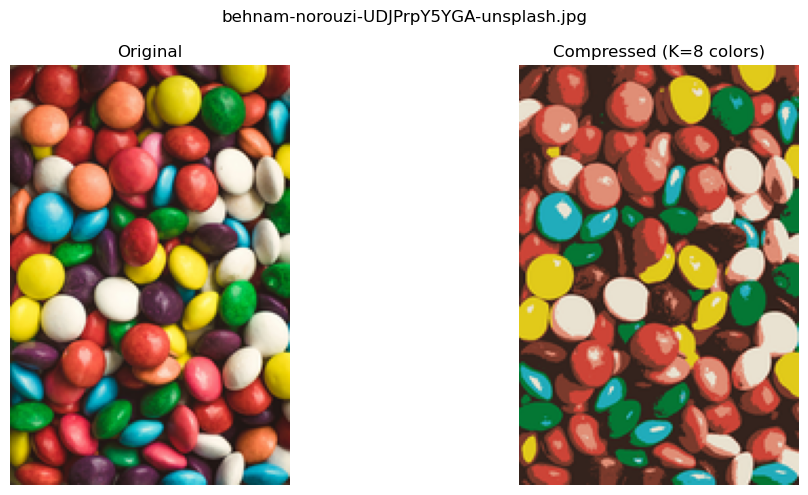

Compressing: caique-nascimento-Ij24Uq1sMwM-unsplash.jpg (K=8)...
  Saved: compressed\caique-nascimento-Ij24Uq1sMwM-unsplash.jpg


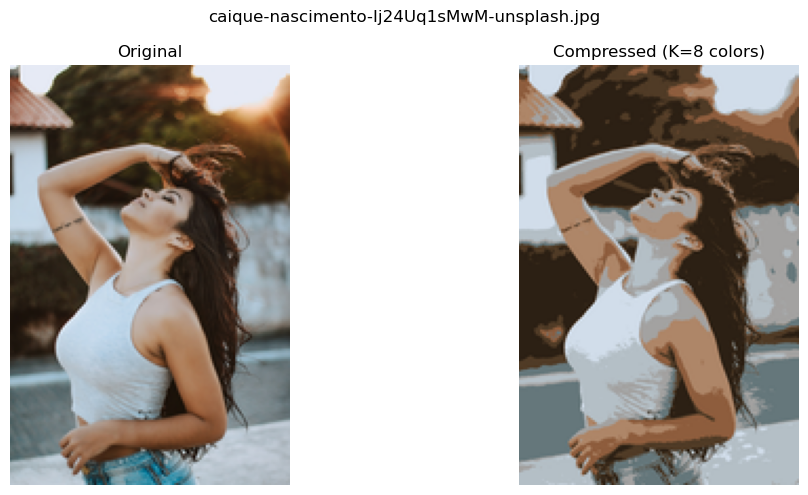

Compressing: derek-thomson-TWoL-QCZubY-unsplash.jpg (K=8)...
  Saved: compressed\derek-thomson-TWoL-QCZubY-unsplash.jpg


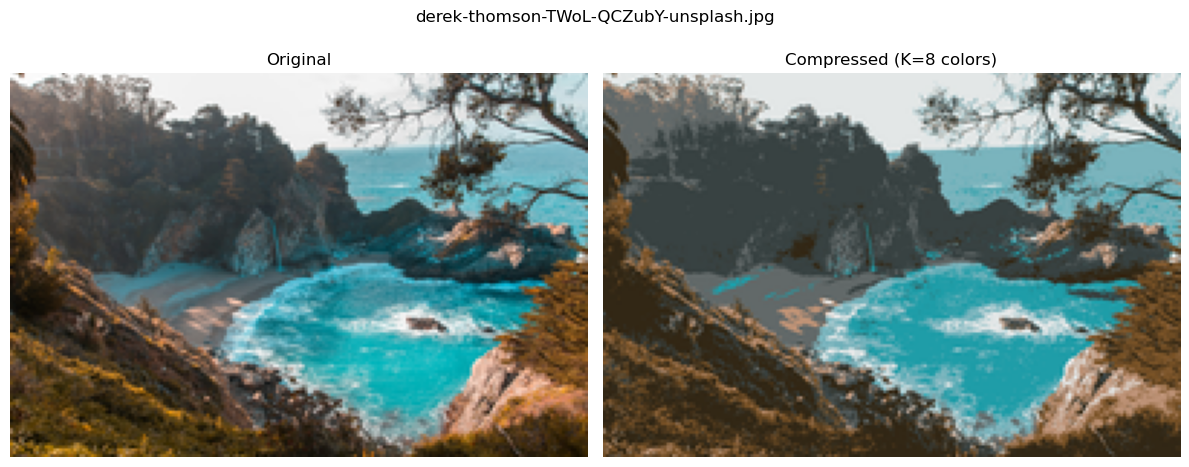

Compressing: edgar-nKC772R_qog-unsplash.jpg (K=8)...
  Saved: compressed\edgar-nKC772R_qog-unsplash.jpg


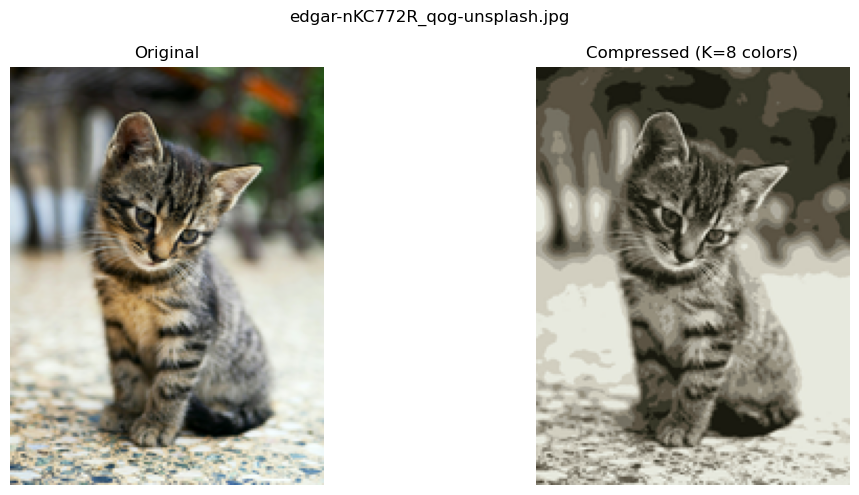

Compressing: fatih-kgqu_qs3B78-unsplash.jpg (K=8)...
  Saved: compressed\fatih-kgqu_qs3B78-unsplash.jpg


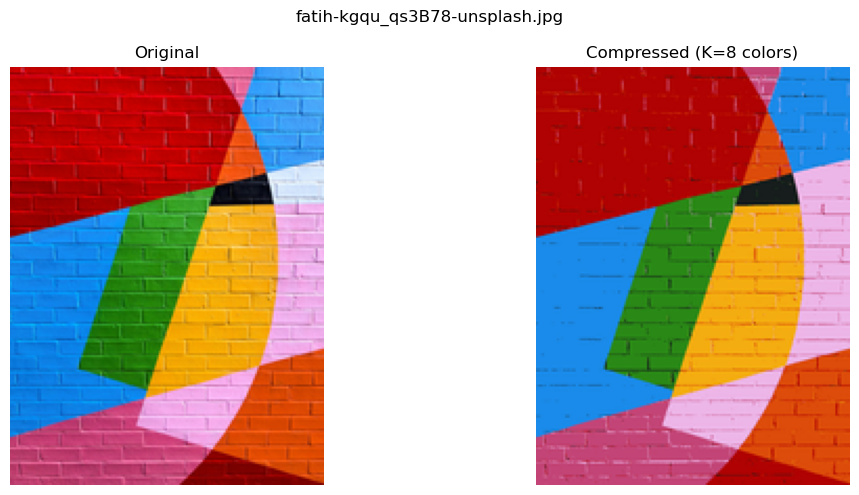

Compressing: greg-rakozy-dqE4raxMqlo-unsplash.jpg (K=8)...
  Saved: compressed\greg-rakozy-dqE4raxMqlo-unsplash.jpg


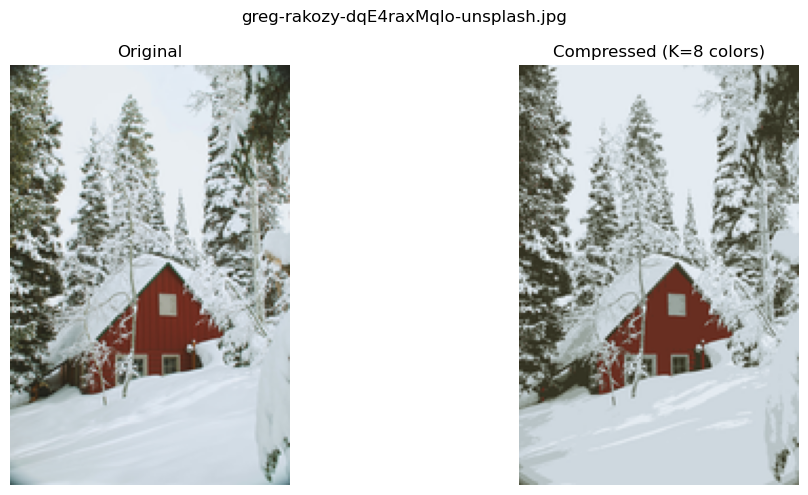

Compressing: hans-jurgen-mager-Fbdr6gXJBVY-unsplash.jpg (K=8)...
  Saved: compressed\hans-jurgen-mager-Fbdr6gXJBVY-unsplash.jpg


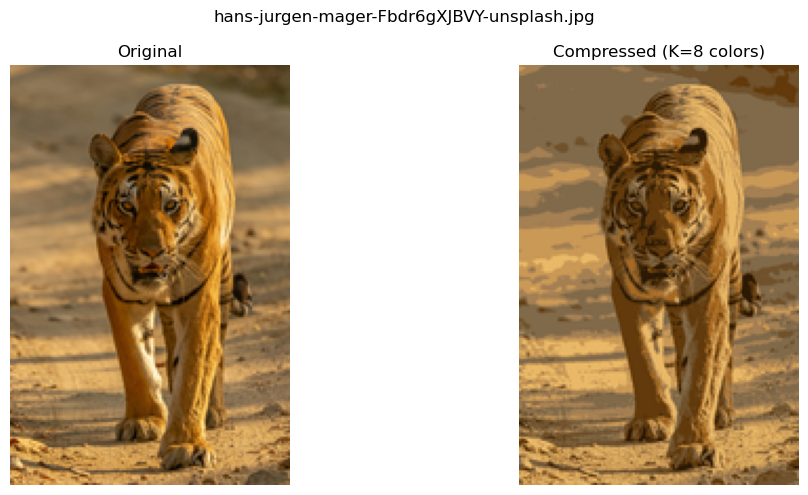

Compressing: joshua-koblin-eqW1MPinEV4-unsplash.jpg (K=8)...
  Saved: compressed\joshua-koblin-eqW1MPinEV4-unsplash.jpg


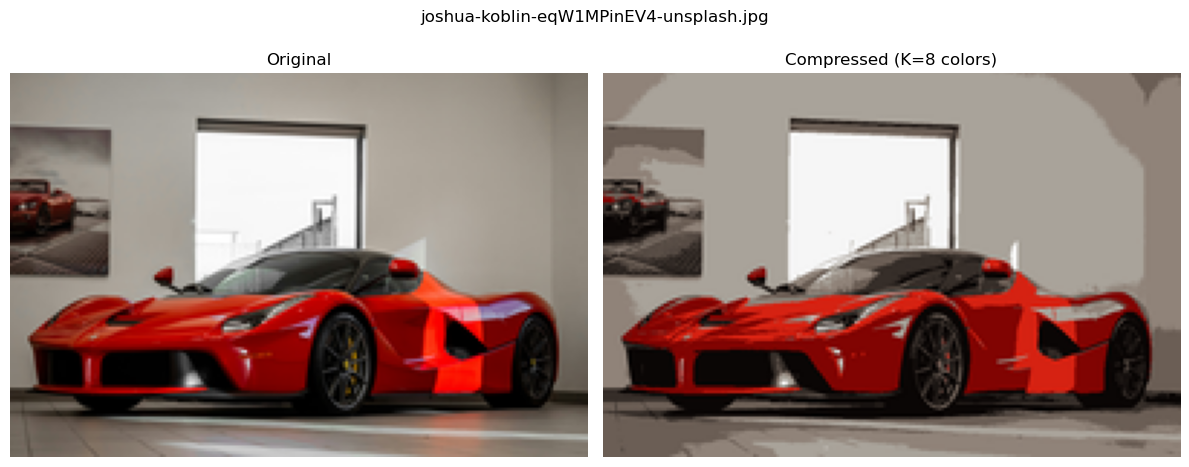

Compressing: karsten-wurth-rafblRbne3o-unsplash.jpg (K=8)...
  Saved: compressed\karsten-wurth-rafblRbne3o-unsplash.jpg


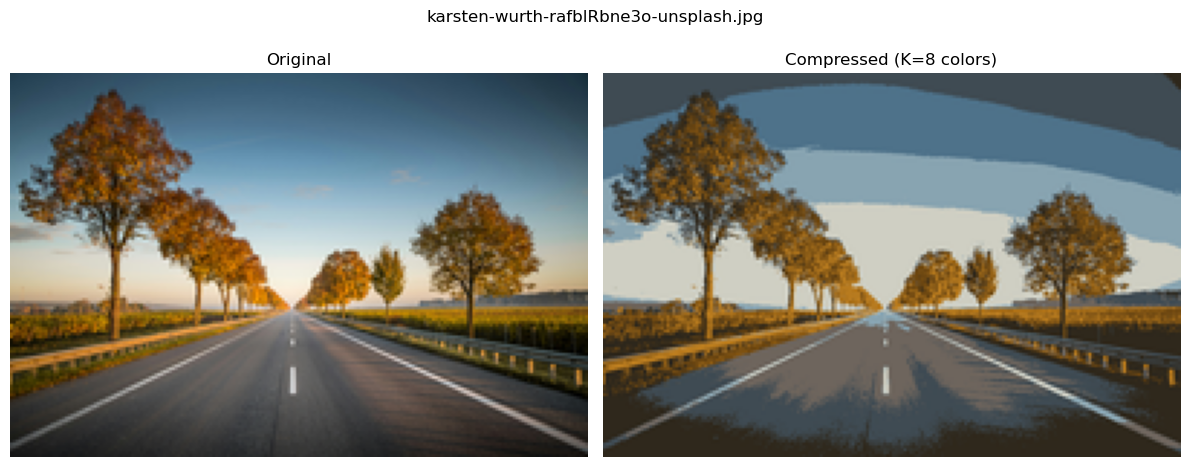

Compressing: richard-brutyo-Sg3XwuEpybU-unsplash.jpg (K=8)...
  Saved: compressed\richard-brutyo-Sg3XwuEpybU-unsplash.jpg


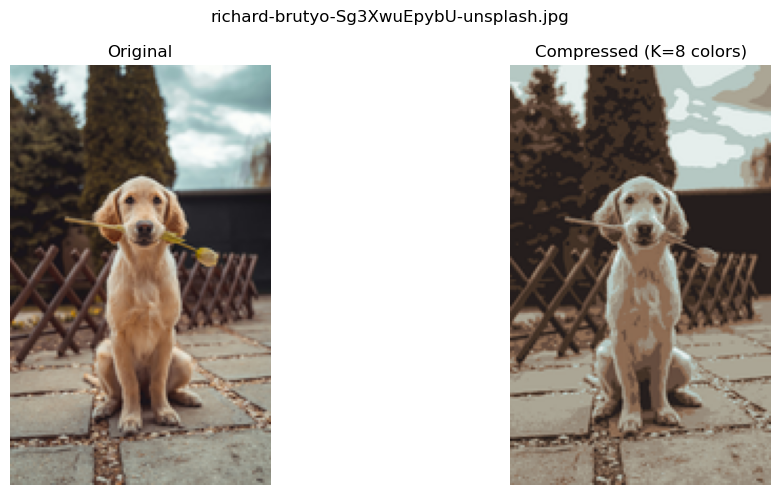

Compressing: sanjeev-nagaraj-caz59CGkQz8-unsplash.jpg (K=8)...
  Saved: compressed\sanjeev-nagaraj-caz59CGkQz8-unsplash.jpg


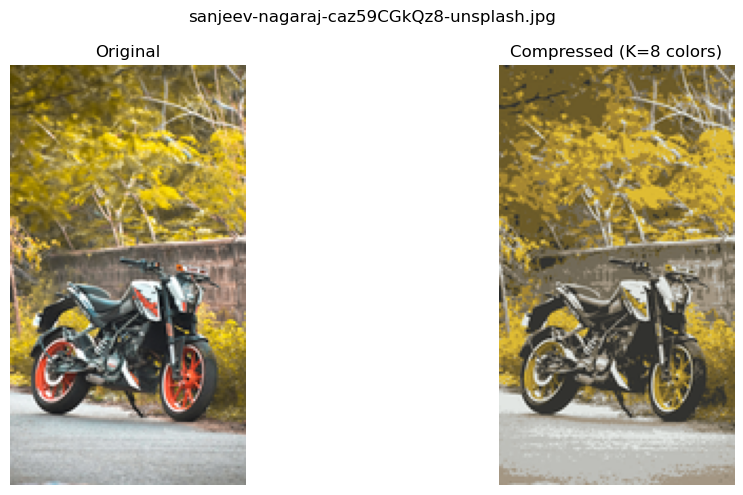

Compressing: uriel-WS4JcpoZz6E-unsplash.jpg (K=8)...
  Saved: compressed\uriel-WS4JcpoZz6E-unsplash.jpg


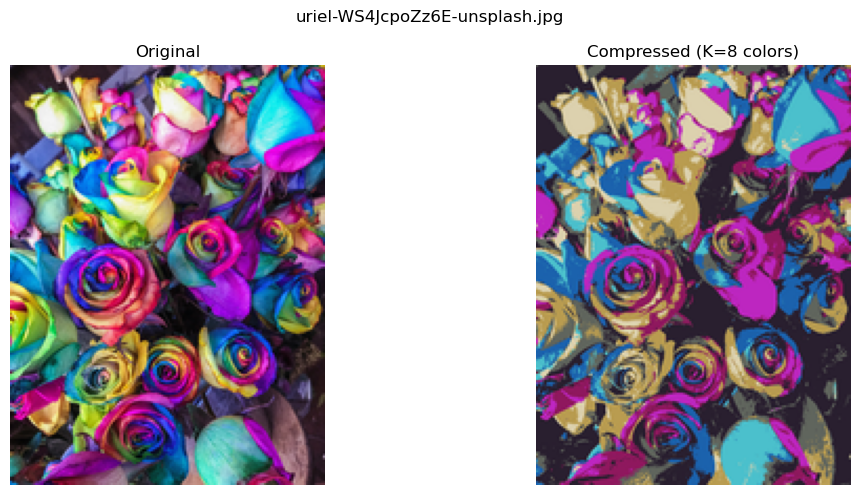

In [12]:
# Process each image: compress and display
for name, img in image_list:
    # Downsample for speed if MAX_DIMENSION is set
    if MAX_DIMENSION:
        h, w = img.shape[:2]
        if max(h, w) > MAX_DIMENSION:
            scale = MAX_DIMENSION / max(h, w)
            img = np.array(Image.fromarray(img).resize((int(w * scale), int(h * scale)), Image.Resampling.LANCZOS))
    print(f"Compressing: {name} (K={K})...")
    compressed, _ = compress_image(img, K)
    
    if OUTPUT_FOLDER:
        out_path = Path(OUTPUT_FOLDER) / name
        Image.fromarray(compressed).save(out_path, quality=95)
        print(f"  Saved: {out_path}")
    
    # Display side-by-side
    def resize_for_display(arr, max_size=MAX_DISPLAY_SIZE):
        h, w = arr.shape[:2]
        if max(h, w) <= max_size:
            return arr
        scale = max_size / max(h, w)
        new_w, new_h = int(w * scale), int(h * scale)
        return np.array(Image.fromarray(arr).resize((new_w, new_h), Image.Resampling.LANCZOS))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(resize_for_display(img))
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(resize_for_display(compressed))
    axes[1].set_title(f"Compressed (K={K} colors)")
    axes[1].axis("off")
    plt.suptitle(name, fontsize=12)
    plt.tight_layout()
    plt.show()

##Compare different K values for an image


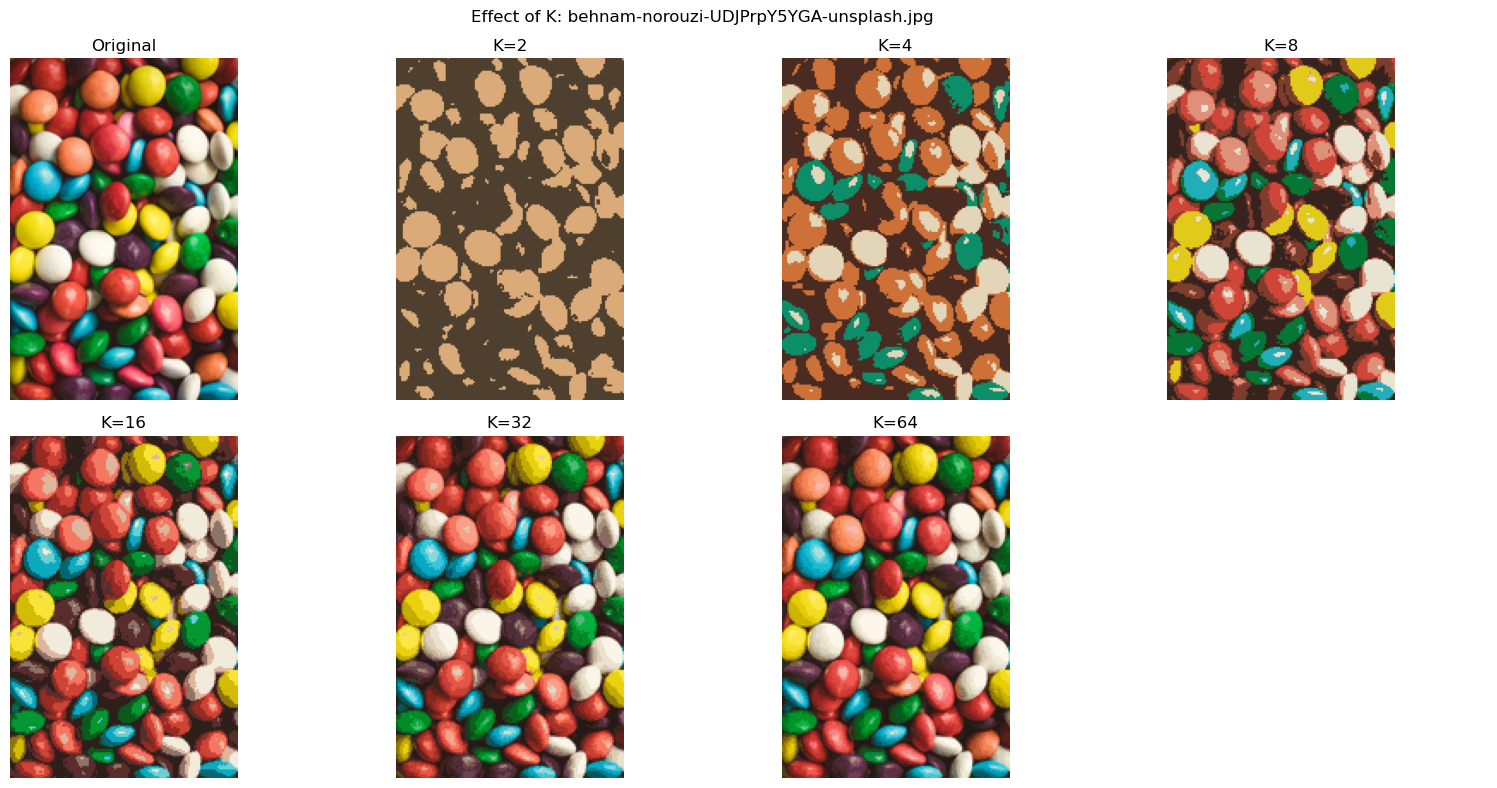

In [13]:
# Compare K values on the first image
if image_list:
    name, img = image_list[0]
    # Downsample for speed (K-means on full-res is very slow)
    max_side = 200
    h, w = img.shape[:2]
    if max(h, w) > max_side:
        scale = max_side / max(h, w)
        small_img = np.array(Image.fromarray(img).resize((int(w * scale), int(h * scale)), Image.Resampling.LANCZOS))
    else:
        small_img = img.copy()
    k_values = [2, 4, 8, 16, 32, 64]
    n = len(k_values)
    fig, axes = plt.subplots(2, (n + 1) // 2 + 1, figsize=(4 * ((n + 1) // 2 + 1), 8))
    axes = axes.flatten()
    
    axes[0].imshow(small_img)
    axes[0].set_title("Original")
    axes[0].axis("off")
    
    for i, k in enumerate(k_values):
        comp, _ = compress_image(small_img, k)
        axes[i + 1].imshow(comp)
        axes[i + 1].set_title(f"K={k}")
        axes[i + 1].axis("off")
    
    for j in range(i + 2, len(axes)):
        axes[j].axis("off")
    plt.suptitle(f"Effect of K: {name}", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No images loaded. Run the previous cells first.")